# Customer Churn Prediction — Model Training & Evaluation

This notebook documents a learner's step-by-step path from **baselines** to **tuned models** for customer churn prediction. It preserves the exploratory flow while keeping code clean and reproducible.

**Workflow**
1) Load processed data
2) Train-test split (stratified)
3) Baseline models: Random Forest and XGBoost
4) Compare by recall and F1 on minority class (churn)
5) Hyperparameter tuning with class imbalance handling
6) Evaluation and reports
7) Feature importance and correlations
8) Save model and summarize next steps


## 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib


## 2. Load processed data

In [2]:
# Load cleaned data generated during preprocessing
path_cleaned = '../data/processed/churn_cleaned_notebook.csv'
df = pd.read_csv(path_cleaned)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_2-Year,Contract_Monthly,PaymentMethod_Card Auto,PaymentMethod_E-Check,PaymentMethod_Mail
0,0,0,1,0,-1.277445,0,0,0,1,0,...,-1.160323,-0.994242,0,0,0,0,1,0,1,0
1,1,0,0,0,0.066327,1,0,1,0,1,...,-0.259629,-0.173244,0,0,0,0,0,0,0,1
2,1,0,0,0,-1.236724,1,0,1,1,0,...,-0.362660,-0.959674,1,0,0,0,1,0,0,1


## 3. Train–test split

Stratification preserves the churn ratio so evaluation is realistic on the test set.

In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('X_train:', X_train.shape, '\nX_test:', X_test.shape)

X_train: (5634, 23) 
X_test: (1409, 23)


## 4. Baseline models

Start simple to establish reference metrics. Train a **Random Forest** and an **XGBoost** with default settings.

In [5]:
# Random Forest baseline
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print('Random Forest baseline:')
print(classification_report(y_test, rf.predict(X_test)))

Random Forest baseline:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [6]:
# XGBoost baseline
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
print('XGBoost baseline:')
print(classification_report(y_test, xgb.predict(X_test)))

# Save the base XGBoost for reference
joblib.dump(xgb, '../models/xgb_base_model_notebook.pkl');

XGBoost baseline:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.71      1409
weighted avg       0.78      0.79      0.78      1409



d:\Projects\customer-churn-prediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:22:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 5. Model selection strategy

We prioritize **recall and F1 for churners (class 1)** because churn is the minority class and catching churners is valuable. Accuracy is less informative under class imbalance. We proceed with **XGBoost** for tuning.

## 6. Tuning round 1 — handle class imbalance and search core params

Compute `scale_pos_weight = negatives / positives` and include it in the search space to counter class imbalance.

In [7]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print('Best Parameters (R1):', search.best_params_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\Projects\customer-churn-prediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:22:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (R1): {'subsample': 0.8, 'scale_pos_weight': np.float64(2.768561872909699), 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
[[761 274]
 [ 72 302]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.81      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



## 7. Feature importance (XGBoost)

Visualize the top features to understand model focus. Values shown are **gain**.

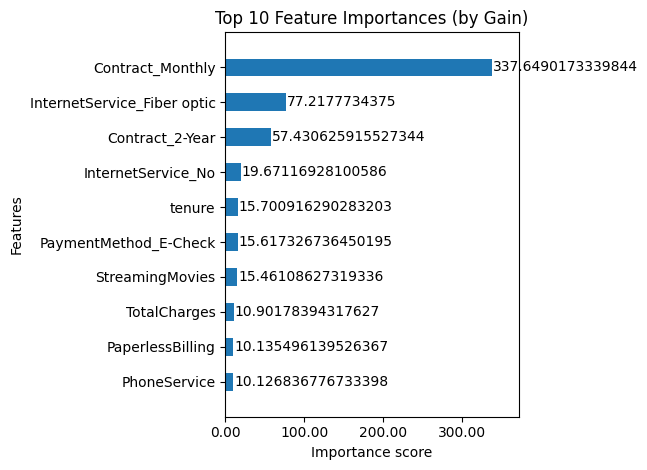

In [8]:
import xgboost as xgb
ax = xgb.plot_importance(best_model, max_num_features=10, importance_type='gain', height=0.5)
plt.title('Top 10 Feature Importances (by Gain)')
plt.grid(False)
plt.tight_layout()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f'{v:.2f}'))
plt.show()

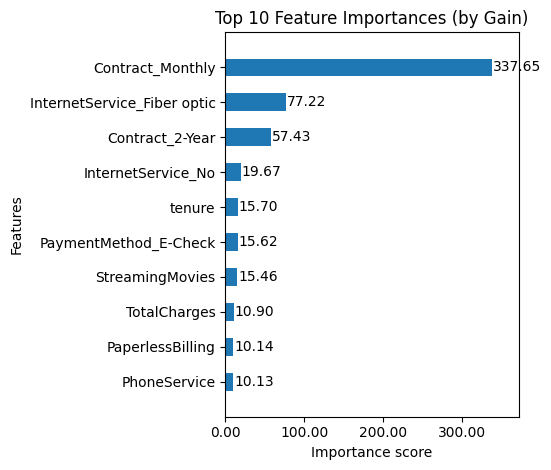

In [15]:
ax = xgb.plot_importance(best_model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Feature Importances (by Gain)")
plt.grid(False)
plt.tight_layout()

# format x-axis to 2 decimals
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# remove old labels and add new rounded ones
for txt in ax.texts:
    val = float(txt.get_text())
    txt.set_text(f'{val:.2f}')

plt.show()

## 8. Correlations in processed data

This is a sanity check to inspect linear correlations in the already-encoded and scaled dataset.

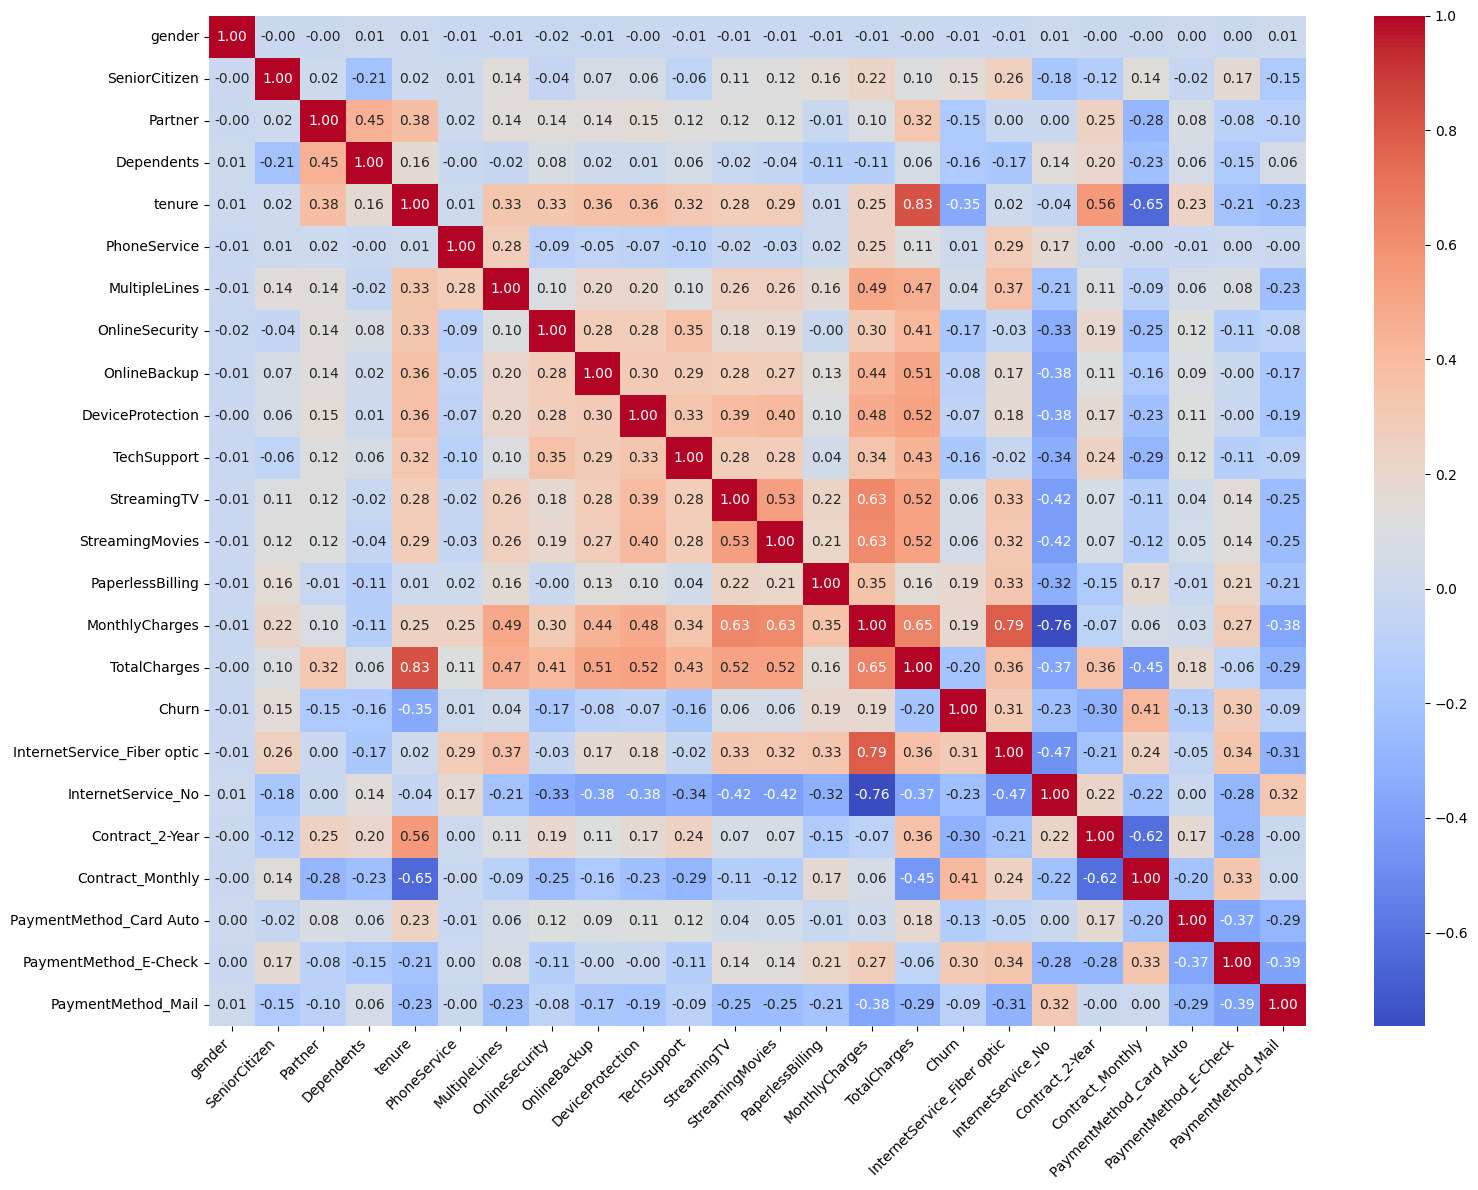

In [12]:
plt.figure(figsize=(16, 12))  # adjust size as needed
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
corr_with_churn = df.corr(numeric_only=True)['Churn'].sort_values(ascending=False)
print(corr_with_churn.head(15))

Churn                          1.000000
Contract_Monthly               0.405103
InternetService_Fiber optic    0.308020
PaymentMethod_E-Check          0.301919
MonthlyCharges                 0.193356
PaperlessBilling               0.191825
SeniorCitizen                  0.150889
StreamingTV                    0.063228
StreamingMovies                0.061382
MultipleLines                  0.040102
PhoneService                   0.011942
gender                        -0.008612
DeviceProtection              -0.066160
OnlineBackup                  -0.082255
PaymentMethod_Mail            -0.091683
Name: Churn, dtype: float64


## 9. Tuning round 2 — extended search (feature selection idea)

Try a broader parameter space. In a full project, you could subset features before this step; here we keep all for clarity.

In [14]:
param_dist_r2 = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 1.5, 2, 2.5, 3]
}

model_r2 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
search_r2 = RandomizedSearchCV(
    estimator=model_r2,
    param_distributions=param_dist_r2,
    n_iter=25,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search_r2.fit(X_train, y_train)
best_model_r2 = search_r2.best_estimator_
print('Best Parameters (R2):', search_r2.best_params_)
print('\nClassification Report (R2):\n', classification_report(y_test, best_model_r2.predict(X_test)))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


d:\Projects\customer-churn-prediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:25:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (R2): {'subsample': 0.6, 'scale_pos_weight': 2, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

Classification Report (R2):
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.56      0.73      0.63       374

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.74      1409
weighted avg       0.80      0.78      0.78      1409



### Model Selection

We trained two versions of the XGBoost model.  
Round 1 gave higher recall but lower precision, while Round 2 was more balanced and accurate.  
Therefore, we choose the **Round 2 tuned model** as the final one to save and use for deployment.


## 10. Save final model

In [17]:
joblib.dump(best_model_r2, '../models/xgb_tuned_model_notebook.pkl');

## 11. Summary and next steps

- Baselines established with Random Forest and XGBoost
- Chose XGBoost due to better recall/F1 on churners
- Tuned hyperparameters with class imbalance consideration via `scale_pos_weight`
- Visualized feature importance and checked correlations
- Saved tuned model for deployment

**Next steps**
- Threshold tuning for business-specific precision–recall trade-offs
- Calibration curves or PR curves
- Integrate into `src/` training pipeline and Streamlit/API app
